<a href="https://colab.research.google.com/github/Nooorab/auction/blob/main/02_Model_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malware Classification Model Implementation

This notebook implements two CNN architectures for malware image classification:

1. **Single-path VGG16 baseline**: Transfer learning approach using pre-trained VGG16
2. **Dual-path CNN with feature fusion**: Custom architecture combining VGG16 with a parallel CNN path

Both architectures will be trained and evaluated across varying training data sizes to investigate data efficiency.

In [13]:
# ============================= ENVIRONMENT SETUP =============================
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm.notebook import tqdm
import random
import json
import pickle
import time
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from google.colab import files
import zipfile

# Check GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", len(tf.config.list_physical_devices('GPU')) > 0)
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU Details:", tf.config.list_physical_devices('GPU'))

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

print("Environment setup complete!")

TensorFlow version: 2.18.0
GPU Available:  True
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Environment setup complete!


In [14]:
# ============================= DATA PREPARATION =============================
print("\n" + "="*30 + " DATASET PREPARATION " + "="*30)

# Constants and configuration
MALWARE_FAMILIES = ['C2LOP.P', 'Dialplatform.B']
IMG_SIZE = (224, 224)  # Size for VGG16 compatibility
TRAIN_TEST_SPLIT = 0.8  # 80% training, 20% testing
DATA_PERCENTAGES = [0.2, 0.4, 0.6, 0.8, 1.0]  # Training data percentages
NUM_RUNS_PER_PERCENTAGE = 3

# Create directories
os.makedirs('data/raw', exist_ok=True)
os.makedirs('data/splits', exist_ok=True)

print("Please upload your malware family ZIP file...")
uploaded = files.upload()  # Upload your Archive.zip file

# Extract the uploaded files
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        print(f"Extracting {filename}...")
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('data/raw')
        print(f"Extracted {filename} to data/raw/")

# Function to load and process images
def load_malware_images():
    images = []
    labels = []
    counts = {}
    label_mapping = {family: idx for idx, family in enumerate(MALWARE_FAMILIES)}

    for family_idx, family in enumerate(MALWARE_FAMILIES):
        family_path = os.path.join('data/raw', family)

        # Get all image files
        image_files = [f for f in os.listdir(family_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]
        counts[family] = len(image_files)

        print(f"Loading {len(image_files)} images for {family}...")
        for img_file in tqdm(image_files):
            img_path = os.path.join(family_path, img_file)
            try:
                # Load as grayscale and resize
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Warning: Could not load image {img_path}")
                    continue

                # Resize to match VGG16 input requirements
                img = cv2.resize(img, IMG_SIZE)

                # Convert grayscale to 3-channel (VGG16 expects RGB)
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

                # Normalize to [0, 1]
                img = img / 255.0

                images.append(img)
                labels.append(family_idx)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    if not images:
        raise ValueError("No images were successfully loaded")

    print(f"Loaded {len(images)} total images")
    print(f"Class distribution: {counts}")

    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels, label_mapping

# Load the dataset
print("Loading and processing images...")
images, labels, label_mapping = load_malware_images()


============================== DATASET PREPARATION ==============================
Please upload your malware family ZIP file...


Saving Archive.zip to Archive.zip
Extracting Archive.zip...
Extracted Archive.zip to data/raw/
Loading and processing images...
Loading 146 images for C2LOP.P...


  0%|          | 0/146 [00:00<?, ?it/s]

Loading 177 images for Dialplatform.B...


  0%|          | 0/177 [00:00<?, ?it/s]

Loaded 323 total images
Class distribution: {'C2LOP.P': 146, 'Dialplatform.B': 177}


In [15]:
# ============================= DATA SPLITTING =============================
print("\n" + "="*30 + " DATA SPLITTING " + "="*30)

# Create train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    images,
    labels,
    test_size=0.2,
    random_state=SEED,
    stratify=labels
)

print(f"Main split - Training set: {X_train.shape[0]} images, Test set: {X_test.shape[0]} images")

# Create multiple training subsets at different percentages
def create_training_subsets():
    """
    Creates multiple training subsets at different percentages.
    Creates 3 distinct subsets for each percentage below 100%.
    """
    training_subsets = {}

    # For 100%, we use the entire training set
    training_subsets[(1.0, 0)] = (X_train, y_train)

    # For other percentages, create multiple distinct subsets
    for percentage in [0.2, 0.4, 0.6, 0.8]:
        for run in range(NUM_RUNS_PER_PERCENTAGE):
            subset_size = int(len(X_train) * percentage)

            # Create stratified subset
            sss = StratifiedShuffleSplit(
                n_splits=1,
                test_size=len(X_train) - subset_size,
                random_state=SEED + run  # Different seed for each run
            )

            # Get indices for this subset
            for train_idx, _ in sss.split(X_train, y_train):
                X_subset = X_train[train_idx]
                y_subset = y_train[train_idx]

                # Store in dictionary
                training_subsets[(percentage, run)] = (X_subset, y_subset)

                # Calculate class distribution
                subset_class_counts = {family: np.sum(y_subset == idx) for family, idx in label_mapping.items()}

                print(f"Created subset {percentage:.0%}-{run+1}: "
                      f"{len(X_subset)} images "
                      f"({subset_class_counts[MALWARE_FAMILIES[0]]} {MALWARE_FAMILIES[0]}, "
                      f"{subset_class_counts[MALWARE_FAMILIES[1]]} {MALWARE_FAMILIES[1]})")

    return training_subsets

# Create all training subsets
print("Creating training subsets...")
training_subsets = create_training_subsets()

# Save the data splits
print("\nSaving data splits...")
os.makedirs('data/splits', exist_ok=True)

# Save test set once (it's the same for all experiments)
np.savez('data/splits/test_set.npz', images=X_test, labels=y_test)

# Save each training subset
for (percentage, run), (X_subset, y_subset) in training_subsets.items():
    filename = f'data/splits/train_{int(percentage*100)}pct_run{run+1}.npz'
    np.savez(filename, images=X_subset, labels=y_subset)

# Save label mapping
with open('data/splits/label_mapping.json', 'w') as f:
    json.dump({str(k): int(v) for k, v in label_mapping.items()}, f)

print("Data splits saved successfully")


============================== DATA SPLITTING ==============================
Main split - Training set: 258 images, Test set: 65 images
Creating training subsets...
Created subset 20%-1: 51 images (23 C2LOP.P, 28 Dialplatform.B)
Created subset 20%-2: 51 images (23 C2LOP.P, 28 Dialplatform.B)
Created subset 20%-3: 51 images (23 C2LOP.P, 28 Dialplatform.B)
Created subset 40%-1: 103 images (47 C2LOP.P, 56 Dialplatform.B)
Created subset 40%-2: 103 images (47 C2LOP.P, 56 Dialplatform.B)
Created subset 40%-3: 103 images (47 C2LOP.P, 56 Dialplatform.B)
Created subset 60%-1: 154 images (70 C2LOP.P, 84 Dialplatform.B)
Created subset 60%-2: 154 images (70 C2LOP.P, 84 Dialplatform.B)
Created subset 60%-3: 154 images (70 C2LOP.P, 84 Dialplatform.B)
Created subset 80%-1: 206 images (93 C2LOP.P, 113 Dialplatform.B)
Created subset 80%-2: 206 images (93 C2LOP.P, 113 Dialplatform.B)
Created subset 80%-3: 206 images (93 C2LOP.P, 113 Dialplatform.B)

Saving data splits...
Data splits saved successfully



============================== SINGLE-PATH MODEL IMPLEMENTATION ==============================
Creating single-path VGG16 model...
Single-path model created successfully


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,153,985 (80.70 MB)

 Trainable params: 6,439,297 (24.56 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

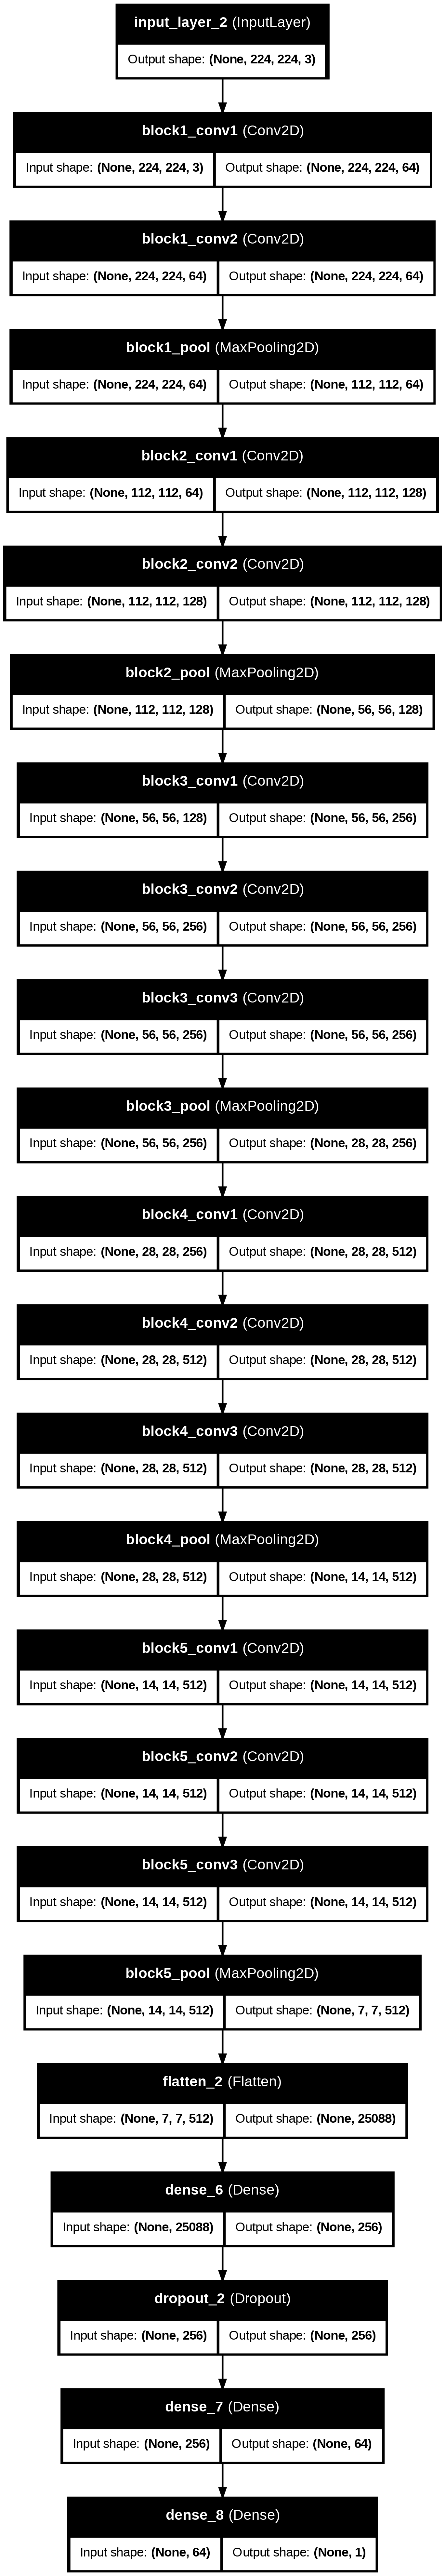

In [3]:
# ============================= SINGLE-PATH MODEL =============================
print("\n" + "="*30 + " SINGLE-PATH MODEL IMPLEMENTATION " + "="*30)
import os
import tensorflow as tf  # Add this import
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout

def create_single_path_model():
    """
    Creates a single-path CNN model using pre-trained VGG16.

    Returns:
        model: Compiled Keras model
    """
    print("Creating single-path VGG16 model...")

    # Start with pre-trained VGG16 (without classification layers)
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze the base model layers to use as feature extractor
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification head
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print("Single-path model created successfully")
    model.summary()
    return model

# Create and visualize the single-path model
single_path_model = create_single_path_model()

# Create directory for saving model visualizations
os.makedirs('models', exist_ok=True)

# Save architecture diagram
tf.keras.utils.plot_model(
    single_path_model,
    to_file='models/single_path_model.png',
    show_shapes=True,
    show_layer_names=True
)


============================== DUAL-PATH MODEL IMPLEMENTATION ==============================
Creating dual-path model with intermediate feature fusion...
Dual-path model created successfully


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 224, 224, 64)   │          1,792 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 224, 224, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 224, 224, 32)   │            896 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 112, 112, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 224, 224, 32)   │            128 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 112, 112, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 112, 112, 32)   │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 112, 112, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 56, 56, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 112, 112, 64)   │            256 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 56, 56, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 56, 56, 64)     │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_5[0][0]  │
├──────────────────────

 Total params: 17,481,089 (66.69 MB)

 Trainable params: 9,844,865 (37.56 MB)

 Non-trainable params: 7,636,224 (29.13 MB)

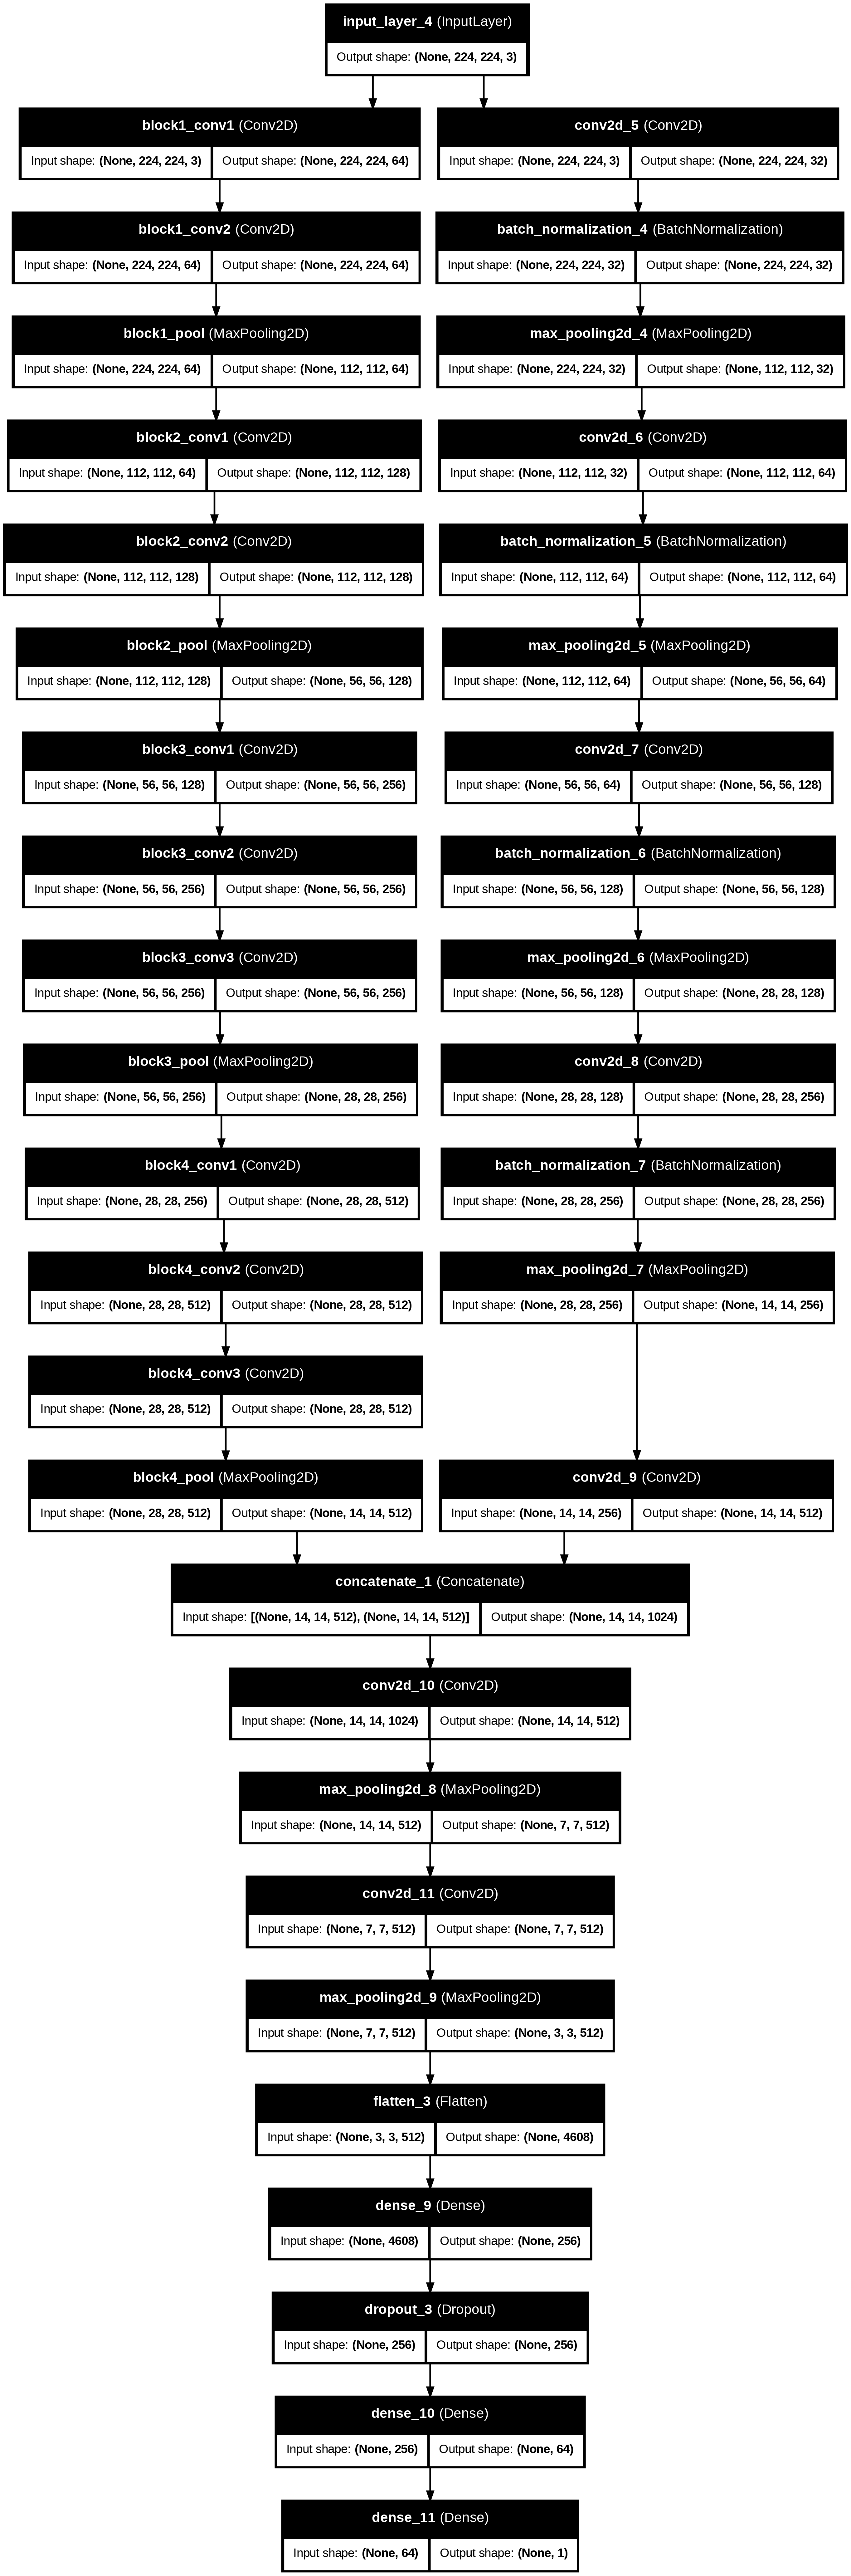

In [5]:
# ============================= DUAL-PATH MODEL =============================
print("\n" + "="*30 + " DUAL-PATH MODEL IMPLEMENTATION " + "="*30)
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Concatenate

def create_dual_path_model():
    """
    Creates a dual-path CNN model with pre-trained VGG16 and custom CNN.
    Features from both paths are fused at an intermediate stage.

    Returns:
        model: Compiled Keras model
    """
    print("Creating dual-path model with intermediate feature fusion...")

    # Input layer
    input_tensor = Input(shape=(224, 224, 3))

    # PATH 1: Pre-trained VGG16 Path
    vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
    # Freeze early layers of VGG16
    for layer in vgg16.layers[:15]:  # Freeze first 15 layers
        layer.trainable = False

    # FIXED: Use block4_pool instead of block4_conv2 to match dimensions with our custom path
    vgg_features = vgg16.get_layer('block4_pool').output  # Shape: (None, 14, 14, 512)

    # PATH 2: Custom CNN Path (designed specifically for malware detection)
    # This path can learn malware-specific patterns that VGG16 might not capture
    custom_path = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
    custom_path = BatchNormalization()(custom_path)
    custom_path = MaxPooling2D(pool_size=(2, 2))(custom_path)  # 112x112

    custom_path = Conv2D(64, (3, 3), activation='relu', padding='same')(custom_path)
    custom_path = BatchNormalization()(custom_path)
    custom_path = MaxPooling2D(pool_size=(2, 2))(custom_path)  # 56x56

    custom_path = Conv2D(128, (3, 3), activation='relu', padding='same')(custom_path)
    custom_path = BatchNormalization()(custom_path)
    custom_path = MaxPooling2D(pool_size=(2, 2))(custom_path)  # 28x28

    custom_path = Conv2D(256, (3, 3), activation='relu', padding='same')(custom_path)
    custom_path = BatchNormalization()(custom_path)
    custom_path = MaxPooling2D(pool_size=(2, 2))(custom_path)  # 14x14

    custom_path = Conv2D(512, (3, 3), activation='relu', padding='same')(custom_path)
    # Now custom_path shape is (None, 14, 14, 512) matching vgg_features

    # FEATURE FUSION: Combine features from both paths
    fused_features = Concatenate()([vgg_features, custom_path])

    # Shared layers after fusion
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(fused_features)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Classification head
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

    # Create the model
    model = Model(inputs=input_tensor, outputs=predictions)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print("Dual-path model created successfully")
    model.summary()
    return model

# Create and visualize the dual-path model
dual_path_model = create_dual_path_model()

# Create directory for saving model visualizations (in case it wasn't created before)
os.makedirs('models', exist_ok=True)

# Save architecture diagram
tf.keras.utils.plot_model(
    dual_path_model,
    to_file='models/dual_path_model.png',
    show_shapes=True,
    show_layer_names=True
)

In [3]:
# ============================= TRAINING FRAMEWORK =============================
print("\n" + "="*30 + " TRAINING FRAMEWORK " + "="*30)

import time  # For timing the training
import seaborn as sns  # For the confusion matrix visualization

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def train_and_evaluate_model(model_creator, model_name, training_data, test_data):
    """
    Trains and evaluates a model on specified training and test data.

    Args:
        model_creator: Function that creates and returns a compiled model
        model_name: Name of the model for saving results
        training_data: Tuple of (X_train, y_train)
        test_data: Tuple of (X_test, y_test)

    Returns:
        results: Dictionary containing training history and evaluation metrics
    """
    X_train, y_train = training_data
    X_test, y_test = test_data

    print(f"Training {model_name}...")
    print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
    print(f"Test data shape: {X_test.shape}, Labels shape: {y_test.shape}")

    # Create the model
    model = model_creator()

    # Create model save directory
    os.makedirs(f'models/{model_name}', exist_ok=True)

    # Setup callbacks
    callbacks = [
        # Save best model
        ModelCheckpoint(
            f'models/{model_name}/best_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        # Reduce learning rate when plateau is reached
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]

    # Train the model
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,  # Max epochs
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    training_time = time.time() - start_time

    print(f"Training completed in {training_time:.2f} seconds")

    # Evaluate the model
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    try:
        roc_auc = roc_auc_score(y_test, y_pred_prob)
    except:
        roc_auc = None

    cm = confusion_matrix(y_test, y_pred)

    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}" if roc_auc else "AUC-ROC: N/A")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(label_mapping.keys()),
                yticklabels=list(label_mapping.keys()))
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'models/{model_name}/confusion_matrix.png')
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'models/{model_name}/training_history.png')
    plt.show()

    # Save results
    results = {
        'model_name': model_name,
        'training_time': training_time,
        'training_size': len(X_train),
        'history': {k: [float(val) for val in v] for k, v in history.history.items()},
        'metrics': {
            'accuracy': float(accuracy),
            'precision': float(precision),
            'recall': float(recall),
            'f1': float(f1),
            'auc_roc': float(roc_auc) if roc_auc else None
        },
        'confusion_matrix': cm.tolist()
    }

    # Save results to file
    os.makedirs('results', exist_ok=True)
    with open(f'results/{model_name}_results.json', 'w') as f:
        json.dump(results, f, indent=4, default=str)

    return results


============================== TRAINING FRAMEWORK ==============================


In [4]:
# ============================= EXPERIMENT RUNNER =============================
print("\n" + "="*30 + " EXPERIMENT RUNNER " + "="*30)

def run_experiments(test_run=True):
    """
    Runs all experiments with both architectures on varying training data sizes.

    Args:
        test_run: If True, only runs a quick test on one dataset

    Returns:
        all_results: Dictionary containing all experiment results
    """
    os.makedirs('results', exist_ok=True)
    all_results = {}

    # Get all training set files
    training_files = [f for f in os.listdir('data/splits') if f.startswith('train_')]

    # If test_run, just use one file
    if test_run:
        print("Running in TEST MODE - using only one training subset")
        training_files = [f for f in training_files if '20pct' in f and 'run1' in f][:1]

    # Sort files to ensure consistent order
    training_files.sort()

    # Load test data once (same for all experiments)
    test_data = np.load('data/splits/test_set.npz')
    X_test, y_test = test_data['images'], test_data['labels']

    # Run experiments for each training set
    for train_file in training_files:
        print(f"\n{'-'*50}")
        print(f"Processing {train_file}...")

        # Parse percentage and run from filename
        percentage = train_file.split('_')[1].split('pct')[0]
        run = train_file.split('run')[1].split('.')[0] if 'run' in train_file else '1'

        # Load training data
        train_data = np.load(f'data/splits/{train_file}')
        X_train, y_train = train_data['images'], train_data['labels']

        # Define experiment names
        single_path_name = f"single_path_{percentage}pct_run{run}"
        dual_path_name = f"dual_path_{percentage}pct_run{run}"

        # Run single-path model
        print(f"\nRunning Single-Path Model ({percentage}%, Run {run})...")
        single_path_results = train_and_evaluate_model(
            create_single_path_model,
            single_path_name,
            (X_train, y_train),
            (X_test, y_test)
        )
        all_results[single_path_name] = single_path_results

        # Run dual-path model
        print(f"\nRunning Dual-Path Model ({percentage}%, Run {run})...")
        dual_path_results = train_and_evaluate_model(
            create_dual_path_model,
            dual_path_name,
            (X_train, y_train),
            (X_test, y_test)
        )
        all_results[dual_path_name] = dual_path_results

        # Save incremental results
        with open('results/all_results.json', 'w') as f:
            json.dump(all_results, f, indent=4, default=str)

    print("\nAll experiments completed!")
    return all_results


============================== EXPERIMENT RUNNER ==============================


In [5]:
# Make sure all necessary imports are available
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import json

In [6]:
# Run a quick test with just one dataset (the 20% dataset)
print("\nRunning quick test on 20% training subset...")
quick_test_results = run_experiments(test_run=True)


Running quick test on 20% training subset...


FileNotFoundError: [Errno 2] No such file or directory: 'data/splits'

In [7]:
# Check if data directories exist
import os

print("Checking directory structure...")
print(f"Current working directory: {os.getcwd()}")

# List root directory contents
print("\nRoot directory contents:")
!ls -la

# Check if data directory exists
if os.path.exists('data'):
    print("\nData directory exists. Contents:")
    !ls -la data

    # Check if splits directory exists
    if os.path.exists('data/splits'):
        print("\nSplits directory exists. Contents:")
        !ls -la data/splits
        print(f"Number of files: {len(os.listdir('data/splits'))}")
    else:
        print("\nSplits directory does not exist.")
else:
    print("\nData directory does not exist.")

Checking directory structure...
Current working directory: /content

Root directory contents:
total 20
drwxr-xr-x 1 root root 4096 Apr  2 07:09 .
drwxr-xr-x 1 root root 4096 Apr  2 06:50 ..
drwxr-xr-x 4 root root 4096 Mar 31 13:40 .config
drwxr-xr-x 2 root root 4096 Apr  2 07:09 results
drwxr-xr-x 1 root root 4096 Mar 31 13:41 sample_data

Data directory does not exist.


In [8]:
# Re-create data directories
import os
os.makedirs('data/splits', exist_ok=True)

print("Data splits not found. We need to process the data again.")
print("Please re-run the data preparation cells from earlier in the notebook.")

Data splits not found. We need to process the data again.
Please re-run the data preparation cells from earlier in the notebook.
